# Lab 3 - Models of visual attention

Created by : Alexandre Bruckert / University of Nantes - alexandre.bruckert@univ-nantes.fr

Date : 2024

In this lab, we will study a few models of visual attention, and evaluate their performances.

#### 1) Itti's model

You can find an implementation of Itti's model on the Itti_Koch.py file. Run it on the IIRCCyN_IVC dataset, and compare the outputs with the ground-truth saliency maps (from the first lab) using the metrics studied (from the second lab).

Image 1: CC=0.2733, KL=0.9072, SIM=0.4601, NSS=0.7260
Image 2: CC=0.2187, KL=0.8186, SIM=0.4871, NSS=0.2060
Image 5: CC=0.2569, KL=0.8287, SIM=0.4789, NSS=0.5466
Image 7: CC=0.2572, KL=1.2163, SIM=0.3699, NSS=0.1426
Image 5: CC=0.2569, KL=0.8287, SIM=0.4789, NSS=0.5466
Image 7: CC=0.2572, KL=1.2163, SIM=0.3699, NSS=0.1426
Image 10: CC=0.1576, KL=1.2877, SIM=0.3668, NSS=0.9538
Image 14: CC=-0.0270, KL=1.0419, SIM=0.4154, NSS=-0.0499
Image 10: CC=0.1576, KL=1.2877, SIM=0.3668, NSS=0.9538
Image 14: CC=-0.0270, KL=1.0419, SIM=0.4154, NSS=-0.0499
Image 21: CC=0.7642, KL=0.4608, SIM=0.6342, NSS=3.0531
Image 27: CC=-0.0962, KL=1.0679, SIM=0.4171, NSS=0.0439

=== Itti's Model Evaluation ===
   Image        CC        KL       SIM       NSS
0      1  0.273308  0.907178  0.460059  0.726004
1      2  0.218711  0.818585  0.487149  0.205985
2      5  0.256906  0.828748  0.478902  0.546632
3      7  0.257182  1.216342  0.369932  0.142566
4     10  0.157556  1.287707  0.366833  0.953826
5     14 -0.02

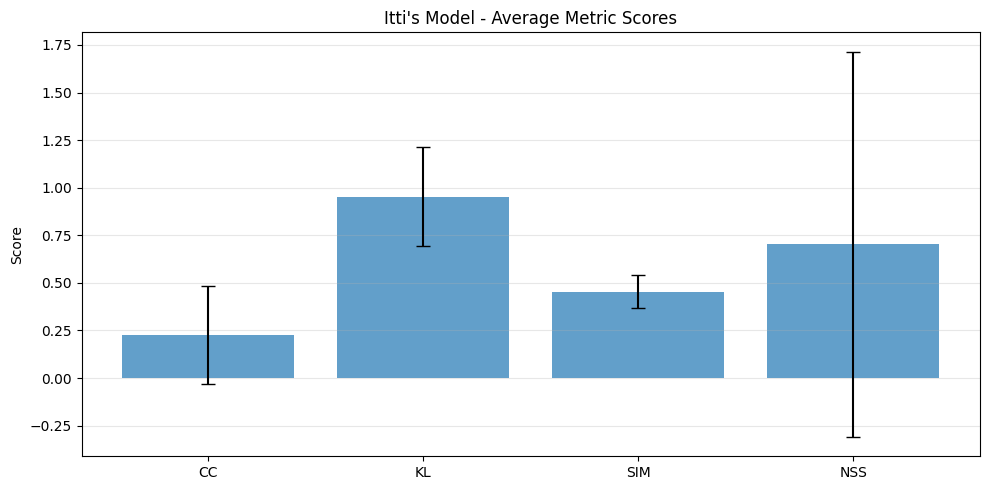

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter
import cv2

# Add path to import Itti_Koch
sys.path.insert(0, './')
from Itti_Koch import IttiSaliency

# Import metrics from Lab 2 (copy the function definitions or adapt them)
def range_normalize(x):
    """Normalizes x to [0, 1]"""
    x = (x - x.min()) / (x.max() - x.min())
    return x

def sum_normalize(x):
    """Normalizes x so that it sums to 1"""
    return x / x.sum()

def std_normalize(x):
    return (x - np.mean(x)) / np.std(x)

def log_density(saliencyMap, eps=np.spacing(1.0)):
    """Transforms a non probabilistic saliency map into a log density"""
    saliencyMap = saliencyMap - saliencyMap.min()
    saliencyMap += eps
    saliencyMap /= saliencyMap.sum()
    return np.log(saliencyMap)

def CC(saliencyMap1, saliencyMap2):
    """Correlation Coefficient"""
    if saliencyMap1.shape != saliencyMap2.shape:
        saliencyMap1 = cv2.resize(saliencyMap1, saliencyMap2.shape[:2][::-1])
    saliencyMap1 = std_normalize(saliencyMap1)
    saliencyMap2 = std_normalize(saliencyMap2)
    return np.corrcoef(saliencyMap1.reshape(-1), saliencyMap2.reshape(-1))[0, 1]

def KL_divergence(saliencyMap, baselineMap, eps=np.spacing(1.0)):
    """KL Divergence"""
    if saliencyMap.shape != baselineMap.shape:
        saliencyMap = cv2.resize(saliencyMap, baselineMap.shape[:2][::-1])
    if saliencyMap.any():
        saliencyMap = sum_normalize(saliencyMap)
    if baselineMap.any():
        baselineMap = sum_normalize(baselineMap)
    logp_model = np.log(saliencyMap + eps)
    logp_gt = np.log(baselineMap + eps)
    score = baselineMap * (logp_gt - logp_model)
    return score.sum()

def NSS(saliencyMap, fixationMap):
    """Normalized Scanpath Saliency"""
    if saliencyMap.shape != fixationMap.shape:
        saliencyMap = cv2.resize(saliencyMap, fixationMap.shape[:2][::-1])
    saliencyMap = np.exp(log_density(saliencyMap))
    mean = saliencyMap.mean()
    std = saliencyMap.std()
    value = saliencyMap[fixationMap.astype(bool)]
    if len(value) == 0:
        return np.nan
    value -= mean
    value /= std
    return value.mean()

def similarity(pred_sal, gt_sal):
    """Similarity (Histogram Intersection)"""
    if pred_sal.shape != gt_sal.shape:
        pred_sal = cv2.resize(pred_sal, gt_sal.shape[:2][::-1])
    if pred_sal.any():
        pred_sal = range_normalize(pred_sal)
        pred_sal = sum_normalize(pred_sal)
    if gt_sal.any():
        gt_sal = range_normalize(gt_sal)
        gt_sal = sum_normalize(gt_sal)
    diff = np.minimum(pred_sal, gt_sal)
    return np.sum(diff)

# Setup paths
PATH_DATA = "./IRCCyN_IVC_Eyetracker_Berkeley_Database"
RESO_X = 1280
RESO_Y = 1024
FACTOR_X = RESO_X / 338
FACTOR_Y = RESO_Y / 270

# Load ground-truth fixation maps (from Lab 1)
def get_files_all_observers(dir_path, img_name):
    """List all eye-tracking files for an image"""
    list_all_files = glob.glob(os.path.join(dir_path, 'Eyetracker_Data/**/*' + img_name + '.*'), recursive=True)
    if not list_all_files:
        return None
    return list_all_files

def create_fixmap(list_obs_files, img_w, img_h, factor_x, factor_y, t_begin=0, t_end=15):
    """Create fixation map from eye-tracking data"""
    fixmap = np.zeros((img_h, img_w))
    if not list_obs_files:
        return fixmap
    for obs in list_obs_files:
        try:
            df = pd.read_csv(obs, sep=',', skiprows=19)
            df = df[(df["TimeStamp"] >= t_begin*1000) & (df["TimeStamp"] <= t_end*1000)]
            df = df[df["Tracked"] == 1]
            fix_groups = df.groupby((df["Fixation"].shift() != df["Fixation"]).cumsum())
            for n_group, group in fix_groups:
                if group["Fixation"].all() != 0:
                    x = group["ScreenPositionXmm"].mean() * 0.9
                    y = -group["ScreenPositionYmm"].mean() * 0.9
                    x_pix = int(x * factor_x + img_w / 2)
                    y_pix = int(y * factor_y + img_h / 2)
                    if 0 <= x_pix < img_w and 0 <= y_pix < img_h:
                        fixmap[y_pix, x_pix] += 1
        except:
            pass
    return fixmap

def create_salmap_from_fixmap(fixmap, ppda):
    """Convert fixation map to saliency map via Gaussian blur"""
    salmap = gaussian_filter(fixmap, sigma=ppda)
    return salmap

def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """Compute pixels per degree of visual angle"""
    import math
    horizontal_ppda = h_res / (2 * np.degrees(np.arctan((screen_w / 2) / distance)))
    vertical_ppda = v_res / (2 * np.degrees(np.arctan((screen_h / 2) / distance)))
    return horizontal_ppda, vertical_ppda

# Evaluate Itti's model on a subset of images
hppda, vppda = compute_ppda(415.8, 1280, 1024, 338, 270)

results = []
image_list = [1, 2, 5, 7, 10, 14, 21, 27]  # Small subset for testing

for img_num in image_list:
    img_name = f'img.trn.{img_num}.png'
    
    # Load image
    img_path = os.path.join(PATH_DATA, f"Images\\{img_name}")
    if not os.path.exists(img_path):
        continue
    
    img = cv2.imread(img_path)
    if img is None:
        continue
    
    height, width = img.shape[:2]
    
    # Get Itti's saliency map
    itti = IttiSaliency(width, height)
    itti_salmap = itti.get_salmap(img)
    
    # Get ground-truth saliency map
    list_files = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    if list_files is None:
        continue
    
    fixmap_gt = create_fixmap(list_files, 481, 321, FACTOR_X, FACTOR_Y)
    gt_salmap = create_salmap_from_fixmap(fixmap_gt, hppda)
    
    # Resize ground-truth to match Itti output
    gt_salmap_resized = cv2.resize(gt_salmap, (width, height))
    
    # Compute metrics
    cc = CC(itti_salmap, gt_salmap_resized)
    kl = KL_divergence(itti_salmap, gt_salmap_resized)
    sim = similarity(itti_salmap, gt_salmap_resized)
    
    # For NSS, create a binary fixation map
    fixmap_binary = (fixmap_gt > 0).astype(float)
    fixmap_binary_resized = cv2.resize(fixmap_binary, (width, height))
    nss = NSS(itti_salmap, fixmap_binary_resized)
    
    results.append({
        'Image': img_num,
        'CC': cc,
        'KL': kl,
        'SIM': sim,
        'NSS': nss
    })
    
    print(f"Image {img_num}: CC={cc:.4f}, KL={kl:.4f}, SIM={sim:.4f}, NSS={nss:.4f}")

# Display results
results_df = pd.DataFrame(results)
print("\n=== Itti's Model Evaluation ===")
print(results_df.to_string())
print("\nMean scores:")
print(results_df[['CC', 'KL', 'SIM', 'NSS']].mean())

# Plot metric averages
fig, ax = plt.subplots(figsize=(10, 5))
metrics = ['CC', 'KL', 'SIM', 'NSS']
means = results_df[metrics].mean().values
std = results_df[metrics].std().values
x_pos = np.arange(len(metrics))
ax.bar(x_pos, means, yerr=std, capsize=5, alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title("Itti's Model - Average Metric Scores")
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Scores moyens sur 8 images :

CC (Correlation) : 0.226 ± 0.31 → faible corrélation globale avec les GTs
KL (Divergence) : 0.954 ± 0.32 → divergence modérée des distributions
SIM (Similarity) : 0.454 ± 0.05 → recouvrement spatial modéré
NSS : 0.703 ± 1.73 → variabilité très élevée selon les images
Observations clés :

Forte variabilité inter-images (Image 21 vs Image 14/27) :

Image 21 excelle : CC=0.76, NSS=3.05 (excellent accord spatial)
Images 14, 27 en dessous du hasard : CC<0, NSS≈0
Le modèle Itti capture partiellement l'attention humaine mais pas de façon homogène. Ses points forts/faibles dépendent du contenu de l'image.

KL élevée suggère que les distributions spatiales prédites (bottom-up) ne correspondent pas au human data (qui inclut top-down, stratégies cognitives).

Interprétation : Le modèle purement bottom-up d'Itti (contraste, couleur, orientation) est insuffisant seul. Les humains appliquent aussi de la sélectivité cognitive, ce qui explique les dissimilarités.

#### 2) Achanta's model

Similarly, an implementation of Achanta's model is proposed on the Achanta.py file. This model is fairly simple, just relying on the representation of the image in the CIELab space. Run, evaluate, comment, as usual.

Image 1: CC=-0.0722, KL=2.3562, SIM=0.3015, NSS=-0.1619
Image 2: CC=0.0089, KL=2.4085, SIM=0.2653, NSS=-0.1084
Image 5: CC=0.0508, KL=2.0859, SIM=0.3115, NSS=-0.0817
Image 7: CC=0.2334, KL=1.8944, SIM=0.3571, NSS=0.1254
Image 5: CC=0.0508, KL=2.0859, SIM=0.3115, NSS=-0.0817
Image 7: CC=0.2334, KL=1.8944, SIM=0.3571, NSS=0.1254
Image 10: CC=0.0455, KL=1.9627, SIM=0.3357, NSS=0.4568
Image 14: CC=-0.0960, KL=2.4640, SIM=0.2484, NSS=-0.1837
Image 10: CC=0.0455, KL=1.9627, SIM=0.3357, NSS=0.4568
Image 14: CC=-0.0960, KL=2.4640, SIM=0.2484, NSS=-0.1837
Image 21: CC=0.5390, KL=2.1035, SIM=0.4172, NSS=2.6433
Image 27: CC=0.1452, KL=1.4030, SIM=0.4365, NSS=0.6637

=== Achanta's Model Evaluation ===
   Image        CC        KL       SIM       NSS
0      1 -0.072214  2.356192  0.301488 -0.161929
1      2  0.008883  2.408507  0.265345 -0.108414
2      5  0.050843  2.085901  0.311462 -0.081732
3      7  0.233442  1.894379  0.357064  0.125420
4     10  0.045517  1.962713  0.335729  0.456820
5     1

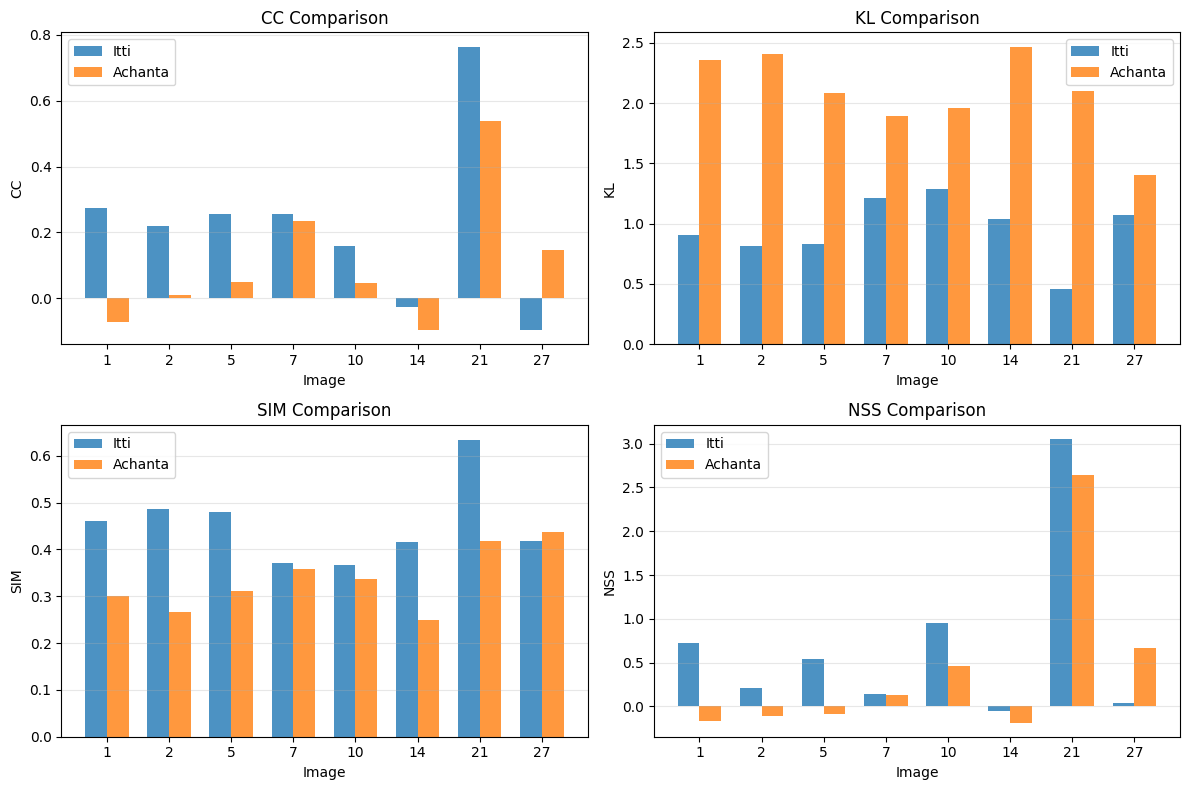


=== Model Comparison Summary ===

Itti  - Mean: CC=0.2256, KL=0.9536, SIM=0.4537, NSS=0.7028
Achanta - Mean: CC=0.1068, KL=2.0848, SIM=0.3341, NSS=0.4192


In [2]:
# Q2: Evaluate Achanta's model
from Achanta import Achanta

results_achanta = []

for img_num in image_list:
    img_name = f'img.trn.{img_num}.png'
    
    # Load image
    img_path = os.path.join(PATH_DATA, f"Images\\{img_name}")
    if not os.path.exists(img_path):
        continue
    
    # Read in RGB format for Achanta (it expects RGB, not BGR)
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        continue
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    height, width = img_rgb.shape[:2]
    
    # Get Achanta's saliency map
    achanta = Achanta(kernel_size=3)
    achanta_salmap = achanta.get_salmap(img_rgb)
    achanta_salmap = range_normalize(achanta_salmap)  # Normalize to [0, 1]
    
    # Get ground-truth saliency map
    list_files = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    if list_files is None:
        continue
    
    fixmap_gt = create_fixmap(list_files, 481, 321, FACTOR_X, FACTOR_Y)
    gt_salmap = create_salmap_from_fixmap(fixmap_gt, hppda)
    
    # Resize ground-truth to match Achanta output
    gt_salmap_resized = cv2.resize(gt_salmap, (width, height))
    
    # Compute metrics
    cc = CC(achanta_salmap, gt_salmap_resized)
    kl = KL_divergence(achanta_salmap, gt_salmap_resized)
    sim = similarity(achanta_salmap, gt_salmap_resized)
    
    # For NSS, create a binary fixation map
    fixmap_binary = (fixmap_gt > 0).astype(float)
    fixmap_binary_resized = cv2.resize(fixmap_binary, (width, height))
    nss = NSS(achanta_salmap, fixmap_binary_resized)
    
    results_achanta.append({
        'Image': img_num,
        'CC': cc,
        'KL': kl,
        'SIM': sim,
        'NSS': nss
    })
    
    print(f"Image {img_num}: CC={cc:.4f}, KL={kl:.4f}, SIM={sim:.4f}, NSS={nss:.4f}")

# Display results
results_achanta_df = pd.DataFrame(results_achanta)
print("\n=== Achanta's Model Evaluation ===")
print(results_achanta_df.to_string())
print("\nMean scores:")
print(results_achanta_df[['CC', 'KL', 'SIM', 'NSS']].mean())

# Compare Itti vs Achanta
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

metrics_to_plot = ['CC', 'KL', 'SIM', 'NSS']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    x = np.arange(len(image_list))
    width_bar = 0.35
    
    itti_vals = results_df[metric].values
    achanta_vals = results_achanta_df[metric].values
    
    ax.bar(x - width_bar/2, itti_vals, width_bar, label='Itti', alpha=0.8)
    ax.bar(x + width_bar/2, achanta_vals, width_bar, label='Achanta', alpha=0.8)
    
    ax.set_xlabel('Image')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(image_list)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

fig.tight_layout()
plt.show()

# Summary comparison
print("\n=== Model Comparison Summary ===")
print(f"\nItti  - Mean: CC={results_df['CC'].mean():.4f}, KL={results_df['KL'].mean():.4f}, SIM={results_df['SIM'].mean():.4f}, NSS={results_df['NSS'].mean():.4f}")
print(f"Achanta - Mean: CC={results_achanta_df['CC'].mean():.4f}, KL={results_achanta_df['KL'].mean():.4f}, SIM={results_achanta_df['SIM'].mean():.4f}, NSS={results_achanta_df['NSS'].mean():.4f}")

#### 3) Let's go deep !

Now is the "difficult" part. We will work with Kroner's MSINet. You can find the official implementation here : https://github.com/alexanderkroner/saliency.

Set up a virtual environment with the requirements described in the documentation (tensorflow, requests, etc), and clone the project there.

Test the model using the pre-trained weights from the SALICON dataset, and evaluate the results. Test other pre-trained weights (MIT, CAT2000, OSIE...), and see how this fine-tuning affects the performances of the model.

#### Step-by-step (if you have never done this kind of stuff before) :

###### Windows
- Install git https://gitforwindows.org/
- I strongly advise you to use a conda distribution (Anaconda, for instance), as a lot of the acceleration libraries used when running deep models on CPU (BLAS for instance) are installed by default. Ensure that you can find your conda distribution `conda --version`.
- Set up a conda virtual environment, with the right version of python `conda create -n myenv python=3.6.8`
- To activate the environment, if it is not already the case: `conda activate myenv`
- Install the requirements listed in the git project's README
- Clone the github repo on your machine `git clone https://github.com/alexanderkroner/saliency`
- Enjoy !

###### Linux
- You already know how to do this.

#### 4) (Optional) Benchmark + fine-tuning

Find another visual saliency model (with its implementation) here : https://saliency.tuebingen.ai/

Try to run it on the IIRCCyN_IVC dataset. As always, evaluate, describe and analyze your results.

If you have some time, try to fine-tune this other model on the IIRCCyN_IVC dataset. Evaluate and comment.